<a href="https://colab.research.google.com/github/Srinivaskolli45/s5_assignment/blob/main/s5_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#assignment 5 for BN,GN and LN 

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms    


In [3]:
!git clone https://github.com/Srinivaskolli45/s4_assignment.git



fatal: destination path 's4_assignment' already exists and is not an empty directory.


In [7]:
import sys
sys.path.append('/content/s4_assignment/')
#sys.path.append('/content/pyTorchModels/models/session8')
from model import *

In [8]:
import torchvision

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
torch.manual_seed(1)
batch_size = 128

#kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
kwargs = dict(num_workers= 4, pin_memory= True if use_cuda else False,shuffle=True,batch_size=batch_size)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomRotation(degrees=7)
                    ])),**kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                        #transforms.RandomRotation(degrees=7)
                    ])),**kwargs)

     


CUDA Available? True


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm_type="nn.BatchNorm2d").to(device)
#model = Net(norm_type="nn.GroupNorm").to(device)
#model = Net(norm_type="nn.LayerNorm").to(device)
summary(model, input_size=(1, 28, 28))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           2,912
       BatchNorm2d-9           [-1, 32, 10, 10]              64
             ReLU-10           [-1, 32, 10, 10]               0
           Conv2d-11             [-1, 10, 8, 8]           2,890
      BatchNorm2d-12             [-1, 10, 8, 8]              20

/content/s4_assignment/model.py:146: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    correct = 0
    processed=0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss +=loss
        pred = output.argmax(dim=1,keepdim=True)
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accurary={100*correct/processed:0.2f}')

    
   # print('\nTrain set: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
   
def test(model, device, test_loader,test_losses=[],test_acc=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    return test_losses,test_acc

In [ ]:
#group normalization
from torch.optim.lr_scheduler import StepLR
model = Net(norm_type="nn.GroupNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loss_gn=[]
test_acc_gn=[]
EPOCHS =20
#schedular = StepLR(optimizer=optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print(f'Epoch--> {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #print("Current learning rate:", optimizer.param_groups[0]['lr'])
    #schedular.step()
    test_loss_gn ,test_acc_gn =test(model, device, test_loader,test_loss_gn ,test_acc_gn)

Epoch--> 1


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-29-e1aaeb9d0b5a>:151: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.3467850685119629 batch_id=468 Accurary=77.50: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]



Test set: Average loss: 0.3235, Accuracy: 9629/10000 (96.29%)

Epoch--> 2


loss=0.24080504477024078 batch_id=468 Accurary=95.97: 100%|██████████| 469/469 [00:37<00:00, 12.64it/s]



Test set: Average loss: 0.1553, Accuracy: 9736/10000 (97.36%)

Epoch--> 3


loss=0.0938335433602333 batch_id=468 Accurary=97.34: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]



Test set: Average loss: 0.1067, Accuracy: 9814/10000 (98.14%)

Epoch--> 4


loss=0.10905960202217102 batch_id=468 Accurary=97.80: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.0856, Accuracy: 9817/10000 (98.17%)

Epoch--> 5


loss=0.08802244812250137 batch_id=468 Accurary=98.04: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.0672, Accuracy: 9872/10000 (98.72%)

Epoch--> 6


loss=0.19350112974643707 batch_id=468 Accurary=98.27: 100%|██████████| 469/469 [00:34<00:00, 13.45it/s]



Test set: Average loss: 0.0600, Accuracy: 9864/10000 (98.64%)

Epoch--> 7


loss=0.10808130353689194 batch_id=468 Accurary=98.37: 100%|██████████| 469/469 [00:34<00:00, 13.44it/s]



Test set: Average loss: 0.0523, Accuracy: 9897/10000 (98.97%)

Epoch--> 8


loss=0.03587436303496361 batch_id=468 Accurary=98.54: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s]



Test set: Average loss: 0.0490, Accuracy: 9891/10000 (98.91%)

Epoch--> 9


loss=0.10015303641557693 batch_id=468 Accurary=98.53: 100%|██████████| 469/469 [00:34<00:00, 13.51it/s]



Test set: Average loss: 0.0453, Accuracy: 9902/10000 (99.02%)

Epoch--> 10


loss=0.05994614586234093 batch_id=468 Accurary=98.67: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s]



Test set: Average loss: 0.0424, Accuracy: 9897/10000 (98.97%)

Epoch--> 11


loss=0.021080458536744118 batch_id=468 Accurary=98.83: 100%|██████████| 469/469 [00:33<00:00, 14.09it/s]



Test set: Average loss: 0.0528, Accuracy: 9877/10000 (98.77%)

Epoch--> 12


loss=0.06657257676124573 batch_id=468 Accurary=98.87: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]



Test set: Average loss: 0.0388, Accuracy: 9918/10000 (99.18%)

Epoch--> 13


loss=0.02910689450800419 batch_id=468 Accurary=98.88: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]



Test set: Average loss: 0.0405, Accuracy: 9897/10000 (98.97%)

Epoch--> 14


loss=0.10801691561937332 batch_id=468 Accurary=98.96: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s]



Test set: Average loss: 0.0446, Accuracy: 9907/10000 (99.07%)

Epoch--> 15


loss=0.07007915526628494 batch_id=468 Accurary=98.88: 100%|██████████| 469/469 [00:34<00:00, 13.58it/s]



Test set: Average loss: 0.0391, Accuracy: 9908/10000 (99.08%)

Epoch--> 16


loss=0.0316971130669117 batch_id=468 Accurary=98.96: 100%|██████████| 469/469 [00:34<00:00, 13.53it/s]



Test set: Average loss: 0.0409, Accuracy: 9901/10000 (99.01%)

Epoch--> 17


loss=0.0480126291513443 batch_id=468 Accurary=98.97: 100%|██████████| 469/469 [00:37<00:00, 12.63it/s]



Test set: Average loss: 0.0428, Accuracy: 9887/10000 (98.87%)

Epoch--> 18


loss=0.03792921081185341 batch_id=468 Accurary=99.05: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]



Test set: Average loss: 0.0458, Accuracy: 9876/10000 (98.76%)

Epoch--> 19


loss=0.05706576630473137 batch_id=468 Accurary=99.04: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]



Test set: Average loss: 0.0407, Accuracy: 9910/10000 (99.10%)

Epoch--> 20


loss=0.03483540192246437 batch_id=468 Accurary=99.06: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]



Test set: Average loss: 0.0370, Accuracy: 9910/10000 (99.10%)



In [ ]:
#Layer normalization
from torch.optim.lr_scheduler import StepLR
model = Net(norm_type="nn.LayerNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loss_ln=[]
test_acc_ln=[]
EPOCHS =20
#schedular = StepLR(optimizer=optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print(f'Epoch--> {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #print("Current learning rate:", optimizer.param_groups[0]['lr'])
    #schedular.step()
    test_loss_ln ,test_acc_ln =test(model, device, test_loader,test_loss_ln ,test_acc_ln)

Epoch--> 1


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-29-e1aaeb9d0b5a>:151: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.7098209261894226 batch_id=468 Accurary=79.29: 100%|██████████| 469/469 [00:37<00:00, 12.65it/s]



Test set: Average loss: 0.6363, Accuracy: 9479/10000 (94.79%)

Epoch--> 2


loss=0.437338262796402 batch_id=468 Accurary=95.22: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]



Test set: Average loss: 0.4113, Accuracy: 9686/10000 (96.86%)

Epoch--> 3


loss=0.31122928857803345 batch_id=468 Accurary=96.49: 100%|██████████| 469/469 [00:36<00:00, 12.72it/s]



Test set: Average loss: 0.3026, Accuracy: 9784/10000 (97.84%)

Epoch--> 4


loss=0.2777726948261261 batch_id=468 Accurary=97.12: 100%|██████████| 469/469 [00:36<00:00, 13.02it/s]



Test set: Average loss: 0.2522, Accuracy: 9804/10000 (98.04%)

Epoch--> 5


loss=0.20089107751846313 batch_id=468 Accurary=97.40: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s]



Test set: Average loss: 0.2254, Accuracy: 9809/10000 (98.09%)

Epoch--> 6


loss=0.26102325320243835 batch_id=468 Accurary=97.66: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.1826, Accuracy: 9860/10000 (98.60%)

Epoch--> 7


loss=0.197073832154274 batch_id=468 Accurary=97.84: 100%|██████████| 469/469 [00:37<00:00, 12.58it/s]



Test set: Average loss: 0.1632, Accuracy: 9870/10000 (98.70%)

Epoch--> 8


loss=0.12202972918748856 batch_id=468 Accurary=97.92: 100%|██████████| 469/469 [00:36<00:00, 12.84it/s]



Test set: Average loss: 0.1475, Accuracy: 9876/10000 (98.76%)

Epoch--> 9


loss=0.10106691718101501 batch_id=468 Accurary=98.12: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s]



Test set: Average loss: 0.1410, Accuracy: 9867/10000 (98.67%)

Epoch--> 10


loss=0.1096365824341774 batch_id=468 Accurary=98.22: 100%|██████████| 469/469 [00:37<00:00, 12.54it/s]



Test set: Average loss: 0.1248, Accuracy: 9892/10000 (98.92%)

Epoch--> 11


loss=0.09200957417488098 batch_id=468 Accurary=98.28: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s]



Test set: Average loss: 0.1296, Accuracy: 9850/10000 (98.50%)

Epoch--> 12


loss=0.1515246033668518 batch_id=468 Accurary=98.38: 100%|██████████| 469/469 [00:36<00:00, 12.73it/s]



Test set: Average loss: 0.1119, Accuracy: 9898/10000 (98.98%)

Epoch--> 13


loss=0.11225149780511856 batch_id=468 Accurary=98.44: 100%|██████████| 469/469 [00:37<00:00, 12.46it/s]



Test set: Average loss: 0.1077, Accuracy: 9885/10000 (98.85%)

Epoch--> 14


loss=0.13391034305095673 batch_id=468 Accurary=98.45: 100%|██████████| 469/469 [00:37<00:00, 12.62it/s]



Test set: Average loss: 0.0959, Accuracy: 9904/10000 (99.04%)

Epoch--> 15


loss=0.08782566338777542 batch_id=468 Accurary=98.45: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.0957, Accuracy: 9887/10000 (98.87%)

Epoch--> 16


loss=0.0723443552851677 batch_id=468 Accurary=98.56: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.1202, Accuracy: 9798/10000 (97.98%)

Epoch--> 17


loss=0.07391059398651123 batch_id=468 Accurary=98.59: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.0895, Accuracy: 9890/10000 (98.90%)

Epoch--> 18


loss=0.08242829889059067 batch_id=468 Accurary=98.60: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]



Test set: Average loss: 0.0940, Accuracy: 9858/10000 (98.58%)

Epoch--> 19


loss=0.060117289423942566 batch_id=468 Accurary=98.70: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]



Test set: Average loss: 0.0761, Accuracy: 9917/10000 (99.17%)

Epoch--> 20


loss=0.14179763197898865 batch_id=468 Accurary=98.68: 100%|██████████| 469/469 [00:34<00:00, 13.45it/s]



Test set: Average loss: 0.0822, Accuracy: 9893/10000 (98.93%)



In [ ]:
#Batch normalization
from torch.optim.lr_scheduler import StepLR
model = Net(norm_type="nn.BatchNorm2d").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loss_bn=[]
test_acc_bn=[]
EPOCHS =20
#schedular = StepLR(optimizer=optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print(f'Epoch--> {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #print("Current learning rate:", optimizer.param_groups[0]['lr'])
    #schedular.step()
    test_loss_bn ,test_acc_bn =test(model, device, test_loader,test_loss_bn ,test_acc_bn)

Epoch--> 1


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-21-e1aaeb9d0b5a>:151: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.10965586453676224 batch_id=468 Accurary=90.66: 100%|██████████| 469/469 [00:34<00:00, 13.48it/s]



Test set: Average loss: 0.1416, Accuracy: 9786/10000 (97.86%)

Epoch--> 2


loss=0.10234590619802475 batch_id=468 Accurary=97.44: 100%|██████████| 469/469 [00:35<00:00, 13.35it/s]



Test set: Average loss: 0.0895, Accuracy: 9829/10000 (98.29%)

Epoch--> 3


loss=0.040025096386671066 batch_id=468 Accurary=98.01: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s]



Test set: Average loss: 0.0644, Accuracy: 9860/10000 (98.60%)

Epoch--> 4


loss=0.08760727196931839 batch_id=468 Accurary=98.29: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0519, Accuracy: 9896/10000 (98.96%)

Epoch--> 5


loss=0.09476467221975327 batch_id=468 Accurary=98.42: 100%|██████████| 469/469 [00:35<00:00, 13.16it/s]



Test set: Average loss: 0.0522, Accuracy: 9885/10000 (98.85%)



Text(0.5, 1.0, 'Test Accuracy')

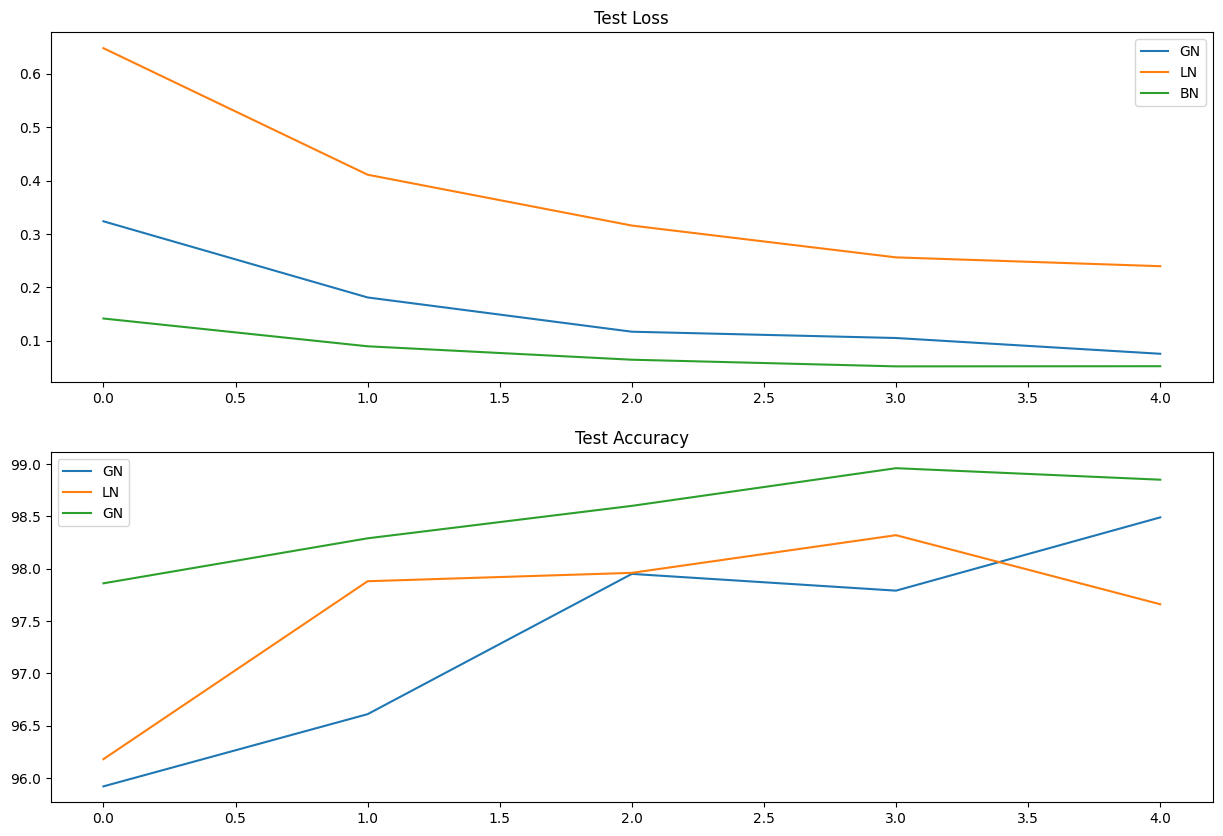

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(15,10))

test_loss_gn = torch.tensor(test_loss_gn, device = 'cpu')
test_loss_ln = torch.tensor(test_loss_ln, device = 'cpu')
test_losses_bn = torch.tensor(test_loss_bn, device = 'cpu')

axs[0].plot(test_loss_gn,label ='GN')
axs[0].plot(test_loss_ln,label ='LN')
axs[0].plot(test_loss_bn,label ='BN')
axs[0].legend()
axs[0].set_title("Test Loss")


axs[1].plot(test_acc_gn,label ='GN')
axs[1].plot(test_acc_ln,label ='LN')
axs[1].plot(test_acc_bn,label ='BN')
axs[1].legend()
axs[1].set_title("Test Accuracy")